In [13]:
import pandas as pd
from geopy.distance import geodesic
from gurobipy import Model, GRB, quicksum
from collections import defaultdict, OrderedDict
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
import math
import json

# Get the absolute path of the parent directory and insert into sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from Prepare_wind_farm_list import wind_farm_list

# Remove a specific wind farm if needed
for wf in wind_farm_list:
    if wf["name"] == "Sofia (Teesside B)":
        wind_farm_list.remove(wf)
        break 

In [14]:
# Define the ports dictionary with ticker keys, names, and coordinates
ports = {
    'NOBGO': {'name': 'Port of Bergen',    'lat': 60.39,    'lon': 5.32},
    'GBABD': {'name': 'Port of Aberdeen',     'lat': 57.14, 'lon': -2.08},
    'NOSTV': {'name': 'Port of Stavanger',    'lat': 58.98, 'lon':  5.73},
    'GBHUL': {'name': 'Port of Hull',      'lat': 53.74,'lon': -0.28},
    'NOKRS': {'name': 'Port of Kristiansand', 'lat': 58.15, 'lon': 8.01},
    'GBTYN': {'name': 'Port of Newcastle', 'lat': 55.00, 'lon': -1.48},
    'NLRTM': {'name': 'Port of Rotterdam', 'lat': 51.94,   'lon': 4.14},
}

vessel_info = [
    {
      'vessel_id': 1,
      'name': 'Vessel 1: NOBGO -> GBABD',
      'start': ports['NOBGO'],  
      'end': ports['GBABD'],    
      'CS': 10,      
      'FC': 0.2,      
      'CLO': 100.0,
      'Q': 1000.0, 
      'speed': 15,          
      'charging_rate': 2,   
      'time_penalty': 0
    },
    {
      'vessel_id': 2,
      'name': 'Vessel 2: NOSTV -> GBHUL',
      'start': ports['NOSTV'],  
      'end': ports['GBHUL'],    
      'CS': 12,
      'FC': 0.25,
      'CLO': 80.0,
      'Q': 950.0, 
      'speed': 15,
      'charging_rate': 2,
      'time_penalty': 0
    },
    {
      'vessel_id': 3,
      'name': 'Vessel 3: NOKRS -> GBTYN',
      'start': ports['NOKRS'],  
      'end': ports['GBTYN'],    
      'CS': 9,
      'FC': 0.22,
      'CLO': 110.0,
      'Q': 1200.0,
      'speed': 15,
      'charging_rate': 2,
      'time_penalty': 0
    },
    {
      'vessel_id': 4,
      'name': 'Vessel 4: NOKRS -> NLRTM',
      'start': ports['NOKRS'], 
      'end': ports['NLRTM'],  
      'CS': 11,
      'FC': 0.19,
      'CLO': 150.0,
      'Q': 900.0,
      'speed': 15,
      'charging_rate': 2,
      'time_penalty': 0
    },
]

full_charge_mode = 1 # 0: flexible charging, 1: forced full recharge at each node

# Vessel-specific parameters 
CS_v  = {}   # Sailing cost per nm
FC_v  = {}   # Energy consumption per nm
CLO_v = {}   # Lost opportunity cost per unit battery capacity
Q_v   = {}   # Maximum battery capacity possible (cargo space)
speed_v = {}           # Sailing speed in nm/hr
charging_rate_v = {}   # Charging speed in energy units/hr
time_penalty_v = {}    # Time cost per hour
for vdata in vessel_info:
    v_id = vdata['vessel_id']
    CS_v[v_id]  = vdata['CS']
    FC_v[v_id]  = vdata['FC']
    CLO_v[v_id] = vdata['CLO']
    Q_v[v_id]   = vdata['Q']
    speed_v[v_id] = vdata['speed']
    charging_rate_v[v_id] = vdata['charging_rate']
    time_penalty_v[v_id] = vdata['time_penalty']

# Create a set of nodes
all_nodes = []
for vdata in vessel_info:
    # Start port
    all_nodes.append({
        'name': vdata['start']['name'],
        'lat':  vdata['start']['lat'],
        'lon':  vdata['start']['lon'],
        'type': f"start_v{vdata['vessel_id']}"
    })
    # End port
    all_nodes.append({
        'name': vdata['end']['name'],
        'lat':  vdata['end']['lat'],
        'lon':  vdata['end']['lon'],
        'type': f"end_v{vdata['vessel_id']}"
    })

# Add wind farms
for wf in wind_farm_list:
    all_nodes.append({
        'name': wf['name'],
        'lat':  wf['lat'],
        'lon':  wf['lon'],
        'type': 'wind_farm'
    })

# Deduplicate
dedup_dict = {}
for nd in all_nodes:
    key = (nd['name'], nd['lat'], nd['lon'], nd['type'])
    dedup_dict[key] = nd

final_list = list(dedup_dict.values())

nodes_dict = {}
for i, nd in enumerate(final_list):
    nodes_dict[i] = nd

N = list(nodes_dict.keys())

def find_node_index_by_name(name):
    for idx in N:
        if nodes_dict[idx]['name'] == name:
            return idx
    return None

# Vessel sets
V = []
vessel_nodes = {}
for vdata in vessel_info:
    v_id = vdata['vessel_id']
    V.append(v_id)
    start_idx = find_node_index_by_name(vdata['start']['name'])
    end_idx   = find_node_index_by_name(vdata['end']['name'])
    vessel_nodes[v_id] = {
        'start': start_idx,
        'end':   end_idx,
    }

wind_farms = [i for i in N if nodes_dict[i]['type'] == 'wind_farm']

# Arc sets per vessel
A_v = {}
for v_id in V:
    si = vessel_nodes[v_id]['start']
    ei = vessel_nodes[v_id]['end']
    vessel_node_set = [si, ei] + wind_farms

    arcs_for_v = []
    for i in vessel_node_set:
        for j in vessel_node_set:
            if i != j:
                arcs_for_v.append((i,j))
    A_v[v_id] = arcs_for_v

# Distance matrix 
D_ij = {}
for i in N:
    for j in N:
        if i != j:
            lat_i, lon_i = nodes_dict[i]['lat'], nodes_dict[i]['lon']
            lat_j, lon_j = nodes_dict[j]['lat'], nodes_dict[j]['lon']
            dist_nm = geodesic((lat_i, lon_i), (lat_j, lon_j)).nm
            D_ij[(i, j)] = dist_nm

# Energy cost
CB_i = {}
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        CB_i[i] = 10.0  
    else:
        CB_i[i] = 5.0

In [15]:
model = Model("Multiple_Vessels")


z = {} # Decision variable: z[(v,i,j)] = 1 if vessel v travels from node i to j.
for v_id in V:
    for (i, j) in A_v[v_id]:
        z[(v_id, i, j)] = model.addVar(vtype=GRB.BINARY, name=f"z_v{v_id}_{i}_{j}")


y = {} # Decision variable: y[i] = 1 if a wind farm station is built at node i.
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        y[i] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}")
    else:
        y[i] = model.addVar(vtype=GRB.BINARY, lb=0, ub=0, name=f"y_{i}")

q_v = {} # Installed Battery Capacity: q_v[v] for vessel v.
for v_id in V:
    q_v[v_id] = model.addVar(lb=0, ub=Q_v[v_id], vtype=GRB.CONTINUOUS, name=f"q_v{v_id}")


battery = {} # Battery variables
charge = {} # Charge variables
for v_id in V:
    vessel_node_set = [vessel_nodes[v_id]['start']] + wind_farms + [vessel_nodes[v_id]['end']]
    for i in vessel_node_set:
        battery[(v_id, i)] = model.addVar(lb=0, name=f"battery_v{v_id}_{i}")
        charge[(v_id, i)] = model.addVar(lb=0, name=f"charge_v{v_id}_{i}")


u = {} # MTZ Variables for Subtour Elimination
for v_id in V:
    si = vessel_nodes[v_id]['start']
    ei = vessel_nodes[v_id]['end']
    node_list_for_v = [si] + wind_farms + [ei]
    M_const = len(node_list_for_v)
    for i in node_list_for_v:
        u[(v_id, i)] = model.addVar(lb=0, ub=M_const, vtype=GRB.CONTINUOUS, name=f"u_v{v_id}_{i}")
    model.addConstr(u[(v_id, si)] == 0, name=f"uStart_v{v_id}")

# Objective Function
obj = quicksum(CS_v[v_id] * D_ij[(i, j)] * z[(v_id, i, j)] for v_id in V for (i, j) in A_v[v_id]) # Sailing cost

for v_id in V:
    vessel_node_set = [vessel_nodes[v_id]['start']] + wind_farms + [vessel_nodes[v_id]['end']]
    obj += quicksum(CB_i[i] * charge[(v_id, i)] for i in vessel_node_set) # Charging cost

obj += quicksum(CLO_v[v_id] * q_v[v_id] for v_id in V) # Lost opportunity cost

for v_id in V:
    time_sailing = quicksum((D_ij[(i, j)] / speed_v[v_id]) * z[(v_id, i, j)] for (i, j) in A_v[v_id]) # Sailing time:
    vessel_node_set = [vessel_nodes[v_id]['start']] + wind_farms + [vessel_nodes[v_id]['end']]
    time_charging = quicksum(charge[(v_id, i)] / charging_rate_v[v_id] for i in vessel_node_set) # Charging time
    obj += time_penalty_v[v_id] * (time_sailing + time_charging) # Time cost

model.setObjective(obj, GRB.MINIMIZE)

# Constraints

# Link battery level to installed capacity: battery at any node must not exceed q_v.
for v_id in V:
    vessel_node_set = [vessel_nodes[v_id]['start']] + wind_farms + [vessel_nodes[v_id]['end']]
    for i in vessel_node_set:
        model.addConstr(battery[(v_id, i)] <= q_v[v_id], name=f"battery_cap_v{v_id}_{i}")

# Initial condition: at the start port, battery equals the installed capacity.
for v_id in V:
    si = vessel_nodes[v_id]['start']
    model.addConstr(battery[(v_id, si)] == q_v[v_id], name=f"init_battery_v{v_id}")

# Set full_charge_mode = 1 to force full charge at each node, or 0 to optimize charging amounts.
if full_charge_mode == 1:
    for v_id in V:
        vessel_node_set = wind_farms + [vessel_nodes[v_id]['end']]
        for i in vessel_node_set:
            if i != vessel_nodes[v_id]['start']:
                model.addConstr(battery[(v_id, i)] == q_v[v_id], name=f"full_charge_v{v_id}_{i}")
else:
    for v_id in V:
        end = vessel_nodes[v_id]['end']
        model.addConstr(battery[(v_id, end)] == q_v[v_id],
                        name=f"full_charge_end_v{v_id}")

# For each vessel, exactly one departure from the start port.
for v_id in V:
    si = vessel_nodes[v_id]['start']
    model.addConstr(quicksum(z[(v_id, si, j)] for (i, j) in A_v[v_id] if i == si) == 1,
                    name=f"DepartStart_v{v_id}")

# For each vessel, exactly one arrival at the end port.
for v_id in V:
    ei = vessel_nodes[v_id]['end']
    model.addConstr(quicksum(z[(v_id, i, ei)] for (i, j) in A_v[v_id] if j == ei) == 1,
                    name=f"ArriveEnd_v{v_id}")

# Flow conservation at intermediate nodes (wind farms) for each vessel.
for v_id in V:
    si = vessel_nodes[v_id]['start']
    ei = vessel_nodes[v_id]['end']
    for nd in [si] + wind_farms + [ei]:
        if nd not in [si, ei]:
            model.addConstr(
                quicksum(z[(v_id, nd, j)] for (ii, j) in A_v[v_id] if ii == nd) -
                quicksum(z[(v_id, k, nd)] for (k, ii) in A_v[v_id] if ii == nd) == 0,
                name=f"FlowCons_v{v_id}_node{nd}")

# Battery Balance Constraints.
for v_id in V:
    max_consumption = max(FC_v[v_id] * D_ij[(i, j)] for (i, j) in A_v[v_id])
    M_energy = Q_v[v_id] + max_consumption
    for (i, j) in A_v[v_id]:
        model.addConstr(
            battery[(v_id, j)] >= battery[(v_id, i)] - FC_v[v_id]*D_ij[(i, j)]
                                + charge[(v_id, j)] - M_energy*(1 - z[(v_id, i, j)]),
            name=f"BatteryBalanceLower_v{v_id}_{i}_{j}")
        model.addConstr(
            battery[(v_id, j)] <= battery[(v_id, i)] - FC_v[v_id]*D_ij[(i, j)]
                                + charge[(v_id, j)] + M_energy*(1 - z[(v_id, i, j)]),
            name=f"BatteryBalanceUpper_v{v_id}_{i}_{j}")
        model.addConstr(
            battery[(v_id, i)] >= FC_v[v_id]*D_ij[(i, j)] - M_energy*(1 - z[(v_id, i, j)]),
            name=f"BatterySufficiency_v{v_id}_{i}_{j}")

# If vessel v arrives at wind_farm i, that i must be chosen
for v_id in V:
    for i in wind_farms:
        model.addConstr(
            quicksum(z[(v_id, k, i)] for (k,ii) in A_v[v_id] if ii == i) <= y[i],
            name=f"StationUse_v{v_id}_i{i}"
        )

# Each vessel visit one wind farm
for v_id in V:
    model.addConstr(
        quicksum(
            quicksum(z[(v_id, k, i)] for (k,ii) in A_v[v_id] if ii == i)
            for i in wind_farms
        ) == 1,
        name=f"OneWindFarmStop_v{v_id}")


model.addConstr(
    quicksum(y[i] for i in wind_farms) == 1,
    name="SingleStation")

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49409 rows, 16970 columns and 225618 nonzeros
Model fingerprint: 0x5fb05916
Variable types: 772 continuous, 16198 integer (16198 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e+00, 8e+03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Presolve removed 49136 rows and 16404 columns
Presolve time: 0.33s
Presolved: 273 rows, 566 columns, 2310 nonzeros
Variable types: 4 continuous, 562 integer (562 binary)
Found heuristic solution: objective 61989.604772
Found heuristic solution: objective 59764.788204
Found heuristic solution: objective 43008.449868

Root relaxation: objective 4.058588e+04, 205 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

In [17]:
if model.status == GRB.OPTIMAL:
    total_cost = 0
    vessel_results = []
    total_obj = model.ObjVal
    print(f"Optimal total cost (all vessels): {total_obj:.2f}\n")

    chosen = [i for i in wind_farms if y[i].X > 0.5]
    print("Chosen station(s):")
    for i in chosen:
        print(f"  Node {i}: {nodes_dict[i]['name']}")
    print("")

    # Reconstruct arcs used by each vessel.
    arcs_used = {}
    for v in V:
        arcs_used[v] = [(i, j) for (i, j) in A_v[v] if z[(v, i, j)].X > 0.5]

    if full_charge_mode == 1:
        output_filename = "Model_itr2_details_full.txt"
    else:
        output_filename = "Model_itr2_details_optional.txt"
    
    # For each vessel, reconstruct route and compute time metrics.
    with open(output_filename, "w") as f:
        f.write(f"Optimal total cost (all vessels): {total_obj:.2f}\n\n")
        
        f.write("Chosen station(s):\n")
        for i in chosen:
            f.write(f"  Node {i}: {nodes_dict[i]['name']}\n")
        f.write("\n")
        for v in V:
            start = vessel_nodes[v]['start']
            end = vessel_nodes[v]['end']
            route_arcs = arcs_used[v]
            # Reconstruct route: if round-trip, follow outgoing mapping; else, sequentially.
            if start == end:
                outgoing = {}
                for (i, j) in route_arcs:
                    outgoing[i] = j
                route_list = [start]
                next_node = outgoing.get(start)
                while next_node is not None and next_node != start:
                    route_list.append(next_node)
                    next_node = outgoing.get(next_node)
                route_list.append(start)
            else:
                route_list = [start]
                current = start
                visited = {start}
                while current != end:
                    found = False
                    for (u, k) in route_arcs:
                        if u == current and k not in visited:
                            route_list.append(k)
                            visited.add(k)
                            current = k
                            found = True
                            break
                    if not found:
                        print(f"Incomplete route encountered for vessel {v}")
                        break

            # Calculate sailing time (hours)
            time_sailing = sum(D_ij[(i, j)] / speed_v[v] for (i, j) in route_arcs)
            # For charging time, use candidate nodes defined earlier.
            cand = [vessel_nodes[v]['start']] + [vessel_nodes[v]['end']]
            port_nodes = [vessel_nodes[v]['start']] + [vessel_nodes[v]['end']]
            for wf in wind_farms:
                if wf not in cand:
                    cand.append(wf)
            time_charging_port = sum(charge[(v, i)].X / charging_rate_v[v] for i in port_nodes)
            time_charging_offshore = sum(charge[(v, i)].X / charging_rate_v[v] for i in wind_farms)
            
            # Reconstruct cost components for reporting.
            sailing_cost = sum(CS_v[v] * D_ij[(i, j)] * z[(v, i, j)].X for (i, j) in A_v[v])
            charging_cost = sum(CB_i[i] * charge[(v, i)].X for i in cand)
            lost_opp_cost = CLO_v[v] * q_v[v].X
            time_cost = time_penalty_v[v] * (time_sailing + time_charging_port + time_charging_offshore)
            vessel_cost = sailing_cost + charging_cost + lost_opp_cost + time_cost
            max_segment = max(D_ij[(i, j)] for (i, j) in route_arcs) if route_arcs else 0
            total_cost += vessel_cost
            direct_dist = D_ij[(start, end)]
            total_dist = sum(D_ij[(i, j)] for (i, j) in route_arcs)

            arc_details = []
            for idx in range(len(route_list) - 1):
                from_node = route_list[idx]
                to_node = route_list[idx+1]
                distance = D_ij[(from_node, to_node)]
                arc_details.append({
                    "from_node": {"node_index": from_node, "name": nodes_dict[from_node]["name"]},
                    "to_node": {"node_index": to_node, "name": nodes_dict[to_node]["name"]},
                    "distance": distance
                })

            vessel_result = {
                "vessel_id": v,
                "vessel_name": vessel_info[v-1]["name"],
                "vessel_cost": vessel_cost,
                "sailing_cost": sailing_cost,
                "lost_opportunity_cost": lost_opp_cost,
                "charging_cost": charging_cost,
                "energy_carried": q_v[v].X,
                "direct_distance": direct_dist,
                "total_traveled_distance": total_dist,
                "percent_direct_distance": 100 * total_dist / direct_dist,
                "max_segment_distance": max_segment,
                "route": [{"node_index": n_idx, "name": nodes_dict[n_idx]["name"]} for n_idx in route_list],
                "arcs": arc_details
            }
            vessel_results.append(vessel_result)

            # Print results for each vessel.
            print(f"Results for {vessel_info[v-1]['name']}:")
            print(f"  Vessel-specific cost: {vessel_cost:.2f}")
            print(f"    - Sailing cost:            {sailing_cost:.2f}")
            print(f"    - Station cost:            {charging_cost:.2f}")
            print(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}")
            print(f"    - Time penalty cost:       {time_cost:.2f}")
            print(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours")
            print(f"    - Time sailing:                {time_sailing:.2f} hours")
            print(f"    - Time charging in port:       {time_charging_port:.2f} hours")
            print(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours")
            print(f"  Battery capacity (q_v):      {q_v[v].X:.2f} energy units")
            print(f"  Direct distance O->D: {direct_dist:.2f} nm")
            print(f"  Total traveled distance: {total_dist:.2f} nm")
            print(f"  Percent of direct distance: {100*total_dist/direct_dist:.2f}%")
            print(f"  Maximum segment distance: {max_segment:.2f} nm")   
            print(f"  Path: {' -> '.join(str(n) for n in route_list)}")
            for n in route_list:
                print(f"    Node {n} => {nodes_dict[n]['name']}")
            print("")

            f.write(f"Results for {vessel_info[v-1]['name']}:\n")
            f.write(f"  Vessel-specific cost: {vessel_cost:.2f}\n")
            f.write(f"    - Sailing cost:            {sailing_cost:.2f}\n")
            f.write(f"    - Charging cost:            {charging_cost:.2f}\n")
            f.write(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}\n")
            f.write(f"    - Time penalty cost:       {time_cost:.2f}\n")
            f.write(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours\n")
            f.write(f"    - Time sailing:                {time_sailing:.2f} hours\n")
            f.write(f"    - Time charging in port:       {time_charging_port:.2f} hours\n")
            f.write(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours\n")
            f.write(f"  Battery capacity (q_v):      {q_v[v].X:.2f} energy units\n")
            f.write(f"  Direct distance O->D: {direct_dist:.2f} nm\n")
            f.write(f"  Total traveled distance: {total_dist:.2f} nm\n")
            f.write(f"  Percent of direct distance: {100*total_dist/direct_dist:.2f}%\n")
            f.write(f"  Maximum segment distance: {max_segment:.2f} nm\n")
            f.write(f"  Path: {' -> '.join(str(n) for n in route_list)}\n")
            for n in route_list:
                f.write(f"    Node {n} => {nodes_dict[n]['name']}\n")
            f.write("\n\n")
        f.write(f"Total cost for all vessels: {total_cost:.2f}")    
        print(f"Total cost for all vessels: {total_cost:.2f}")
      
    print("\nSolution details have been saved to", output_filename)

    solution_data = {}
    solution_data["optimal_total_cost"] = total_obj
    solution_data["chosen_stations"] = [{"node_index": i, "name": nodes_dict[i]["name"]} for i in chosen]
    solution_data["vessels"] = vessel_results

    results_file_name = "Model_itr2_results_structured.txt"
    results_file_path = "/Users/markusagersborg/Library/CloudStorage/OneDrive-NTNU/Master/Optimeringsmodell/Results"
    output_path = os.path.join(results_file_path, results_file_name)
    with open(output_path, "w") as f:
        json.dump(solution_data, f, indent=2)
    print("\nStructured solution data saved as", results_file_name)
else:
    print("No optimal solution found. Status =", model.status)

Optimal total cost (all vessels): 41353.93

Chosen station(s):
  Node 46: Sørvest D

Results for Vessel 1: NOBGO -> GBABD:
  Vessel-specific cost: 9933.86
    - Sailing cost:            4403.60
    - Station cost:            682.74
    - Lost opportunity cost:   4847.53
    - Time penalty cost:       0.00
  Total time:                  73.39 hours
    - Time sailing:                29.36 hours
    - Time charging in port:       19.80 hours
    - Time charging offshore:      24.24 hours
  Battery capacity (q_v):      48.48 energy units
  Direct distance O->D: 302.47 nm
  Total traveled distance: 440.36 nm
  Percent of direct distance: 145.59%
  Maximum segment distance: 242.38 nm
  Path: 0 -> 46 -> 1
    Node 0 => Port of Bergen
    Node 46 => Sørvest D
    Node 1 => Port of Aberdeen

Results for Vessel 2: NOSTV -> GBHUL:
  Vessel-specific cost: 9521.60
    - Sailing cost:            4552.93
    - Station cost:            680.52
    - Lost opportunity cost:   4288.16
    - Time penalty 

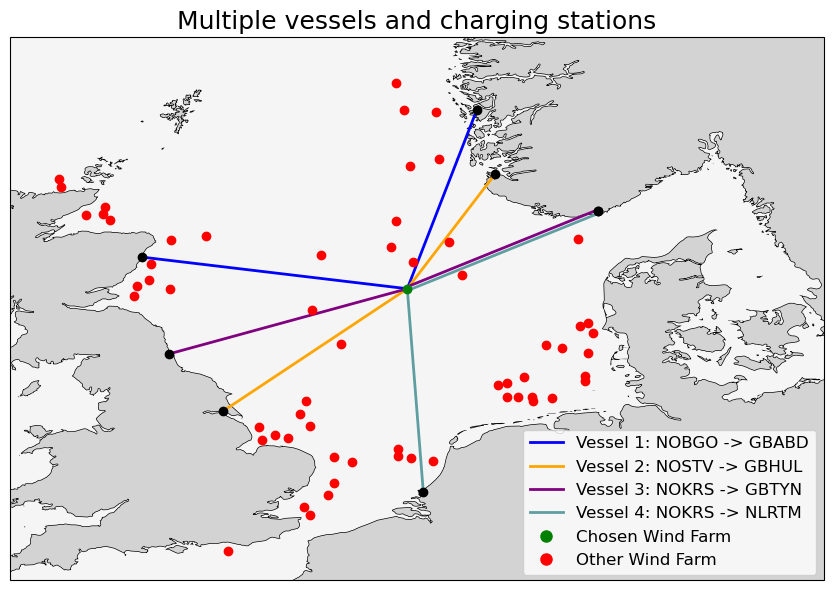


Matplotlib figure saved as Model_itr2_map_full.png


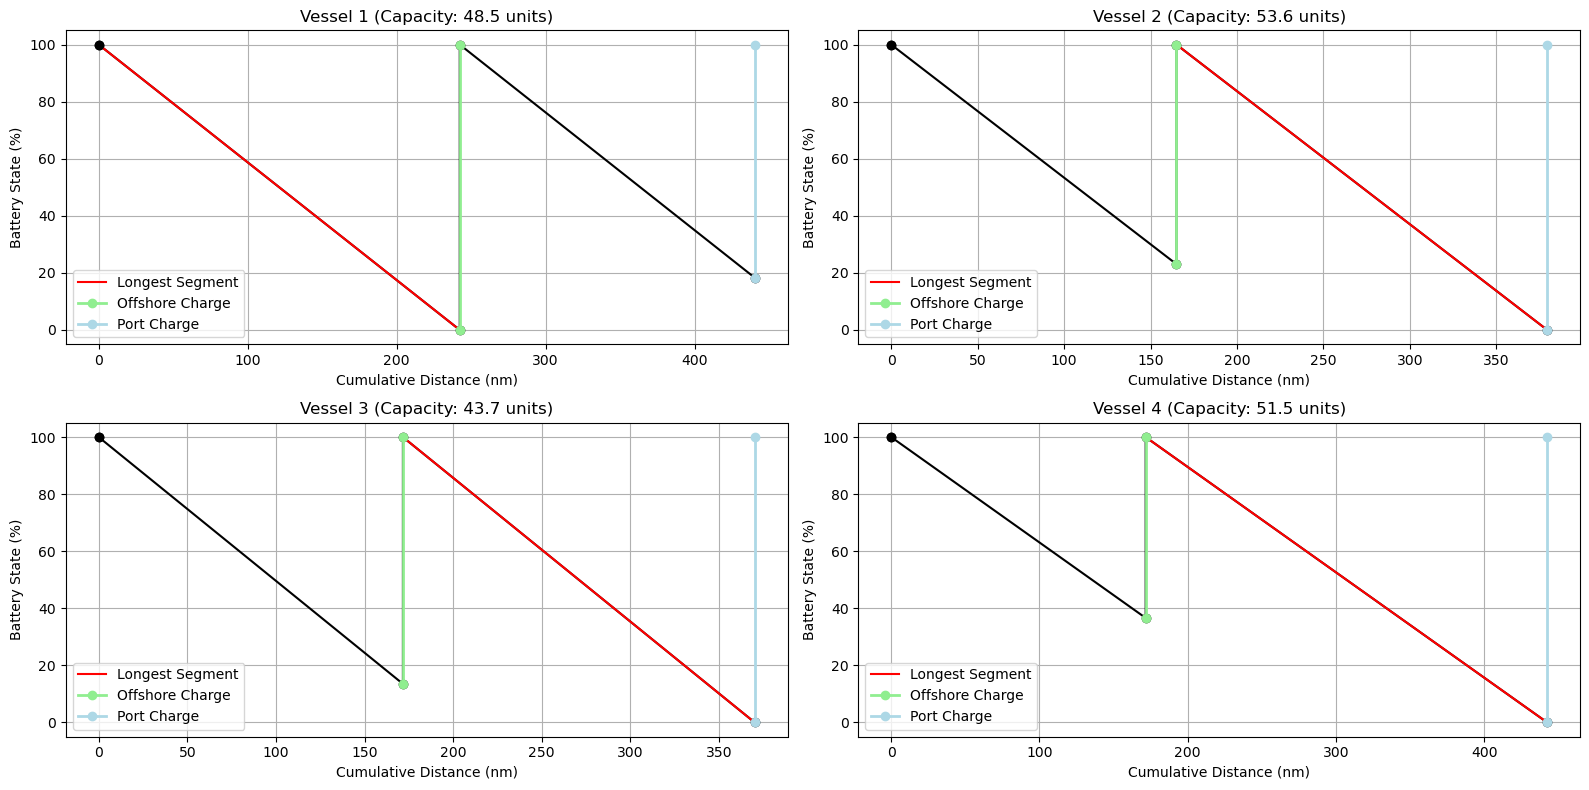


Matplotlib battery state figure saved as Model_itr2_battery_state_full.png


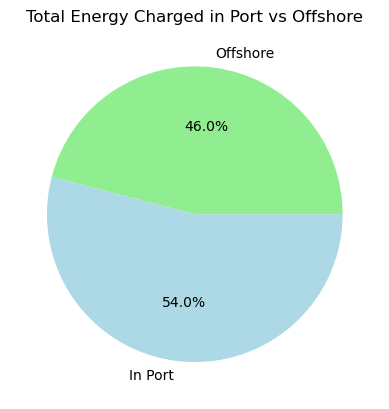


Matplotlib pie figure saved as Model_itr2_battery_state_full.png


In [19]:
def reconstruct_route(arcs, start, end):
    route = [start]
    current = start
    while current != end:
        found = False
        for (u, k) in arcs:
            if u == current:
                route.append(k)
                current = k
                found = True
                break
        if not found:
            print("Incomplete route encountered for vessel")
            break
    return route

def offset_line(lon1, lat1, lon2, lat2, idx, n_lanes, base_offset=0.04):
    dx = lon2 - lon1
    dy = lat2 - lat1
    length = np.hypot(dx, dy)
    if length == 0:
        return (lon1, lat1), (lon2, lat2)
    nx = -dy / length
    ny = dx / length
    offset_pos = (idx - 1) - (n_lanes - 1) / 2
    offset_dist = offset_pos * base_offset * 2
    offset_lon1 = lon1 + offset_dist * nx
    offset_lat1 = lat1 + offset_dist * ny
    offset_lon2 = lon2 + offset_dist * nx
    offset_lat2 = lat2 + offset_dist * ny
    return (offset_lon1, offset_lat1), (offset_lon2, offset_lat2)

if model.status == GRB.OPTIMAL:
    arc_usage = defaultdict(list)
    for v_id in V:
        for (i, j) in arcs_used[v_id]:
            arc_usage[(i, j)].append(v_id)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='whitesmoke')
    ax.set_extent([-5, 13, 50, 62], crs=ccrs.PlateCarree())

    for i in N:
        lat, lon = nodes_dict[i]['lat'], nodes_dict[i]['lon']
        t = nodes_dict[i]['type']
        if i in wind_farms and y[i].X > 0.5:
            color = 'green'
        elif t.startswith('start') or t.startswith('end'):
            color = 'black'
        elif t == 'wind_farm':
            color = 'red'
        else:
            color = 'gray'
        ax.plot(lon, lat, 'o', color=color, markersize=6,
                transform=ccrs.PlateCarree(), zorder=5)

    route_colors = ['blue','orange','purple','cadetblue','green','darkred','cadetblue']
    legend_handles = []
    for idx, v_id in enumerate(V):
        vessel_color = route_colors[idx % len(route_colors)]
        vessel_label = vessel_info[v_id - 1]['name']
        line = mlines.Line2D([], [], color=vessel_color, linewidth=2, label=vessel_label)
        legend_handles.append(line)
    chosen_station_marker = mlines.Line2D([], [], color='green', marker='o',
                                          linestyle='None', markersize=8,
                                          label='Chosen Wind Farm')
    legend_handles.append(chosen_station_marker)
    other_station_marker = mlines.Line2D([], [], color='red', marker='o',
                                         linestyle='None', markersize=8,
                                         label='Other Wind Farm')
    legend_handles.append(other_station_marker)

    for idx, v_id in enumerate(V):
        color = route_colors[idx % len(route_colors)]
        arcs_v = arcs_used[v_id]
        si = vessel_nodes[v_id]['start']
        ei = vessel_nodes[v_id]['end']
        route_list = [si]
        current = si
        visited = {si}
        while current != ei:
            found_next = False
            for (u, k) in arcs_v:
                if u == current and k not in visited:
                    route_list.append(k)
                    visited.add(k)
                    current = k
                    found_next = True
                    break
            if not found_next:
                break
        for step in range(len(route_list)-1):
            p1 = route_list[step]
            p2 = route_list[step+1]
            lon1, lat1 = nodes_dict[p1]['lon'], nodes_dict[p1]['lat']
            lon2, lat2 = nodes_dict[p2]['lon'], nodes_dict[p2]['lat']
            shared_vessels = arc_usage[(p1, p2)]
            shared_vessels_sorted = sorted(shared_vessels)
            lane_idx = shared_vessels_sorted.index(v_id) + 1
            n_lanes = len(shared_vessels)
            (offset_lon1, offset_lat1), (offset_lon2, offset_lat2) = offset_line(
                lon1, lat1, lon2, lat2, lane_idx, n_lanes
            )
            ax.plot([offset_lon1, offset_lon2],
                    [offset_lat1, offset_lat2],
                    color=color, linewidth=2,
                    transform=ccrs.PlateCarree(), zorder=3)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title("Multiple vessels and charging stations", fontsize=18)
    ax.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(0.99, 0.01), borderaxespad=0., fontsize=12)

    plt.tight_layout()
    plt.show()

    if full_charge_mode == 1:
        output_filename = "Model_itr2_map_full.png"
    else:
        output_filename = "Model_itr2_map_optional.png"
    fig.savefig(output_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
    print("\nMatplotlib figure saved as", output_filename)

    n_vessels = len(V)
    ncols = 2
    nrows = math.ceil(n_vessels / ncols)
    fig_battery, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharex=False)
    axes = axes.flatten()  # ensure axes is a 1D array

    # Initialize totals for energy charged (assumed in same units as battery[(v, node)].X)
    total_offshore_energy = 0.0
    total_inport_energy = 0.0

    for idx, v in enumerate(V):
        ax = axes[idx]
        arcs_v = arcs_used[v]
        start = vessel_nodes[v]['start']
        end = vessel_nodes[v]['end']
        # Reuse the same route reconstruction function.
        route_list = reconstruct_route(arcs_v, start, end)
        
        # Determine the longest leg along the route.
        max_leg = -1
        max_leg_index = None
        for i in range(len(route_list) - 1):
            leg_dist = D_ij[(route_list[i], route_list[i+1])]
            if leg_dist > max_leg:
                max_leg = leg_dist
                max_leg_index = i

        # Build piecewise data for the battery profile.
        consumption_x, consumption_y = [], []
        consumption_x_max, consumption_y_max = [], []
        vertical_segments = []  # Each as (x, y_start, y_end, color)

        current_dist = 0.0
        start_batt = battery[(v, route_list[0])].X
        prev_percent = (100.0 * start_batt / q_v[v].X) if q_v[v].X > 0 else 0
        prev_dist = current_dist

        for i in range(len(route_list) - 1):
            i_node = route_list[i]
            j_node = route_list[i+1]
            leg_dist = D_ij[(i_node, j_node)]
            current_dist = prev_dist + leg_dist
            
            # Compute battery percentage before any charging at the arrival node.
            arrival_batt = battery[(v, i_node)].X - FC_v[v] * leg_dist
            arrival_percent = (100.0 * arrival_batt / q_v[v].X) if q_v[v].X > 0 else 0

            # Append consumption segment.
            consumption_x.extend([prev_dist, current_dist])
            consumption_y.extend([prev_percent, arrival_percent])
            if i == max_leg_index:
                consumption_x_max.extend([prev_dist, current_dist])
                consumption_y_max.extend([prev_percent, arrival_percent])

            # Compute departure battery level after charging at the node.
            departure_batt = battery[(v, j_node)].X
            departure_percent = (100.0 * departure_batt / q_v[v].X) if q_v[v].X > 0 else 0
            
            # Determine charging type: offshore if node type is wind_farm.
            jump_color = 'lightgreen' if nodes_dict[j_node]['type'] == 'wind_farm' else 'lightblue'
            vertical_segments.append((current_dist, arrival_percent, departure_percent, jump_color))
            
            # Compute the energy charged during this event.
            energy_charged = departure_batt - arrival_batt
            if jump_color == 'lightgreen':
                total_offshore_energy += energy_charged
            else:
                total_inport_energy += energy_charged

            prev_dist = current_dist
            prev_percent = departure_percent

        # Plot the battery consumption segments.
        ax.plot(consumption_x, consumption_y, color='black', marker='o')
        # Highlight the longest leg.
        ax.plot(consumption_x_max, consumption_y_max, color='red', label='Longest Segment')
        ax.plot(0, 100, 'o', color='black')  # starting point

        # Use flags to avoid duplicate legend labels for charging events.
        offshore_plotted = False
        port_plotted = False
        # Plot vertical jumps for charging.
        for (x_val, y_start, y_end, col) in vertical_segments:
            label = None
            if col == 'lightgreen' and not offshore_plotted:
                label = 'Offshore Charge'
                offshore_plotted = True
            elif col == 'lightblue' and not port_plotted:
                label = 'Port Charge'
                port_plotted = True
            ax.plot([x_val, x_val], [y_start, y_end], color=col, marker='o', linewidth=2,
                    label=label)
        vessel_name = vessel_info[v - 1]['name']
        installed_cap = q_v[v].X
        ax.set_xlabel("Cumulative Distance (nm)")
        ax.set_ylabel("Battery State (%)")
        ax.set_title(f"Vessel {idx+1} (Capacity: {installed_cap:.1f} units)")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    battery_filename = "Model_itr2_battery_state_full.png" if full_charge_mode == 1 else "Model_itr2_battery_state_optional.png"
    fig_battery.savefig(battery_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    print("\nMatplotlib battery state figure saved as", battery_filename)

    # Create a pie chart for total energy charged in port vs offshore.
    fig_pie, ax_pie = plt.subplots()
    labels = ['Offshore', 'In Port']
    sizes = [total_offshore_energy, total_inport_energy]
    ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
    ax_pie.set_title("Total Energy Charged in Port vs Offshore")
        
    pie_filename = "Model_itr2_pie_full.png" if full_charge_mode == 1 else "Model_itr2_pie_optional.png"
    fig_pie.savefig(pie_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    print("\nMatplotlib pie figure saved as", battery_filename)
else:
    print("No optimal solution found. Status =", model.status)